# Introduction

### Problem

In the project this week, we will conduct detailed model evaluation, data quality testing and behavioral testing for the news classification model from the week 1 project.

1. We will look at evaluation metrics beyond overall accuracy and f1 score (per-class metrics, confusion matrix, per-class false positive and false negative errors)
2. We will implement bootstrap sampling to measure confidence intervals of model performance metrics
3. We will implement behavioral tests using a popular open source library called checklist
4. [advanced] Advanced data quality and behavioral tests

### Deliverables
1. Test set per-class accuracy, precision, recall and F-1 score
2. Test set confusion matrix, and per-class false positive, false negative errors
3. 95% confidence intervals for test set metrics as estimated via bootstrap sampling
4. Behavioral tests for the trained news classification model, using checklist.
5. [Optional] Advanced data quality and behavioral tests



## Step1: Prereqs & Installation

Download & Import all the necessary libraries we need throughout the project.

In [1]:
# Install all the required dependencies for the project

!pip install numpy
!pip install scikit-learn
!pip install gensim
!pip install sentence-transformers
!pip install matplotlib
!pip install great_expectations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-no

In [3]:
# Package imports that will be needed for this project

import numpy as np
import json
from sentence_transformers import SentenceTransformer
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as sklearn_metrics

In [4]:
# Global Constants

LABEL_SET = [
    'Business',
    'Sci/Tech',
    'Software and Developement',
    'Entertainment',
    'Sports',
    'Health',
    'Toons',
    'Music Feeds'
]

EMBEDDING_MODEL = 'all-mpnet-base-v2'
DATA_URL = 'https://corise-mlops.s3.us-west-2.amazonaws.com/project2/agnews.zip'

## Step 2: Download and Load Dataset

[AG News](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) is a collection of more than 1 million news articles gathered from more than 2000 news sources by an academic news search engine. The news topic classification dataset & benchmark was first used in [Character-level Convolutional Networks for Text Classification (NIPS 2015)](https://arxiv.org/abs/1509.01626). The dataset has the text description (summary) of the news article along with some metadata. **For this project, we will use a slightly modified (cleaned up) version of this dataset**

Schema:
* Source - News publication source
* URL - URL of the news article
* Title - Title of the news article
* Description - Summary description of the news article
* Embedding - 768 dimensional embedding representation of the news article text (description)
* Category (Label) - News category

Sample row in this dataset:
```
{
   'description': 'A capsule carrying solar material from the Genesis space probe has made a crash landing at a US Air Force training facility in the US state of Utah.',
   'id': 86273,
   'label': 'Entertainment',
   'source': 'Voice of America',
   'title': 'Capsule from Genesis Space Probe Crashes in Utah Desert',
   'Embedding': [....],
   'url': 'http://www.sciencedaily.com/releases/2004/09/040908090621.htm'
}
```

In [5]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

DIRECTORY_NAME = "data"


def download_dataset():
    """
    Download the dataset. The zip contains three files: train.json, test.json and unlabeled.json
    """
    http_response = urlopen(DATA_URL)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=DIRECTORY_NAME)


# Expensive operation so we should just do this once
download_dataset()


In [6]:
Datasets = {}

for ds in ['train', 'test']:
    with open('data/{}.json'.format(ds), 'r') as f:
        Datasets[ds] = json.load(f)
    print("Loaded Dataset {0} with {1} rows".format(ds, len(Datasets[ds])))

print("\nExample dataset row:\n")
pprint(Datasets['train'][0])

Loaded Dataset train with 25000 rows
Loaded Dataset test with 50000 rows

Example dataset row:

{'description': 'A capsule carrying solar material from the Genesis space '
                'probe has made a crash landing at a US Air Force training '
                'facility in the US state of Utah.',
 'embedding': [0.014944990165531635,
               -0.012602416798472404,
               0.022629551589488983,
               -0.004524254705756903,
               0.030837086960673332,
               -0.036378033459186554,
               -0.009855341166257858,
               0.03661152347922325,
               0.006519013550132513,
               0.01946776919066906,
               -0.04761530086398125,
               0.022138206288218498,
               0.032830338925123215,
               0.04278254881501198,
               0.02766306698322296,
               0.043008096516132355,
               0.0386490561068058,
               0.009227401576936245,
               -0.0084016676992177

## Step 3: Data Quality Tests

In Week 2 instruction, we learned about the importance of evaluating data quality across the ML lifecycle:
* When building your first ML model, you often have no data and have to invest in annotation resources to get labels
* Dataset labels can be noisy as they are collected from a variety of different sources.
* Real world evolves (drift) and so should the datasets you’re using to train models (to make sure they evolve along with it).

[Great Expectations](https://docs.greatexpectations.io/docs/) is a popular Python library for validating data in Machine Learning pipelines. It contains several built-in Expectation types to configure tests, as well as integrations with common data structures used to store datasets (e.g. Pandas dataframes, CSV files, MySQL databases etc). We will be using this library to define and run some data quality tests for our dataset. The goal and scope of the exercise here is to get you acquainted with the library and practice of testing for data quality.

Useful references for this section:
1. Documentation: https://docs.greatexpectations.io/docs/
2. Using Great Expections in Jupyter: https://docs.greatexpectations.io/docs/guides/miscellaneous/how_to_quickly_explore_expectations_in_a_notebook
3. List of predefined Expecations: https://greatexpectations.io/expectations/
4. Creating custom Expecations for Pandas dataframes: https://github.com/great-expectations/great_expectations/blob/develop/docs_rtd/guides/how_to_guides/creating_and_editing_expectations/how_to_create_custom_expectations_for_pandas.rst

In [7]:
import pandas as pd
import great_expectations as ge
from great_expectations.dataset import PandasDataset, MetaPandasDataset

class AGNewsPandasDataset(PandasDataset):

    _data_asset_type = "AGNewsPandasDataset"

    @MetaPandasDataset.column_map_expectation
    def expect_column_string_not_null_or_empty(self, column):
        """
        [TO BE IMPLEMENTED]

        Write a custom expectation that checks that the string column's value for each
        row is not NULL and not an empty string

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        return column.map(lambda x: x is not None and x != "")

    @MetaPandasDataset.column_map_expectation
    def expect_column_embedding_dimensionality(self, column, dimension):
        """
        [TO BE IMPLEMENTED]

        Write a custom expectation that checks that the embedding column's value for each
        row is not NULL and dim(embedding) == dimension

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        return column.map(lambda x: x is not None and len(x) == dimension)


    @MetaPandasDataset.column_map_expectation
    def expect_column_in_range(self, column, range_min, range_max):
        """
        [TO BE IMPLEMENTED]

        Write a custom expectation that checks that the column's value for each
        row is in range [range_min, range_max]

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        return column.map(lambda x: range_min <= int(x) <= range_max)

    @MetaPandasDataset.column_map_expectation
    def expect_column_embedding_unit_norm(self, column):
        """
        [TO BE IMPLEMENTED]

        Write a custom expectation that checks that the embedding column's value for each
        row is not NULL and norm(embedding) == 1

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        return column.map(lambda x: x is not None and round(np.linalg.norm(np.array(x)),5) == 1)


In [8]:
Dataframes = {}

for ds in ['train', 'test']:
  df = pd.DataFrame.from_records(Datasets[ds])
  Dataframes[ds] = ge.from_pandas(
    df,
    dataset_class=AGNewsPandasDataset
  )


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




In [9]:
Dataframes['train'].info()


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




<class '__main__.AGNewsPandasDataset'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           25000 non-null  int64 
 1   source       25000 non-null  object
 2   title        25000 non-null  object
 3   url          25000 non-null  object
 4   rank         24726 non-null  object
 5   description  25000 non-null  object
 6   embedding    25000 non-null  object
 7   label        25000 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.5+ MB


In [10]:
for ds in ['train', 'test']:
    """
    [TO BE IMPLEMENTED]

    Expect columns in Dataframes[ds] to match the column set:
    {'id', 'source', 'title', 'url', 'rank', 'description', 'embedding', 'label'}
    """
    Dataframes[ds].expect_table_columns_to_match_set(column_set={'id', 'source', 'title', 'url', 'rank', 'description', 'embedding', 'label'}, exact_match=True)

    """
    [TO BE IMPLEMENTED]

    Expect the "id" column in Dataframes[ds] to be unique
    """
    Dataframes[ds].expect_column_values_to_be_unique(column="id")

    """
    [TO BE IMPLEMENTED]

    Expect the "description" column in Dataframes[ds] not not be null or empty
    """
    Dataframes[ds].expect_column_string_not_null_or_empty(column="description")

    """
    [TO BE IMPLEMENTED]

    Expect the "embedding" column in Dataframes[ds] should be non-NULL and dimensionality = 768
    (Run this after implementing `expect_column_embedding_dimensionality` above)
    """
    Dataframes[ds].expect_column_embedding_dimensionality(column="embedding", dimension=768)

    """
    [TO BE IMPLEMENTED]

    Expect the "embedding" column in Dataframes[ds] should be unit norm vectors
    (Run this after implementing `expect_column_embedding_unit_norm` above)
    """
    Dataframes[ds].expect_column_embedding_unit_norm(column="embedding")

    """
    [TO BE IMPLEMENTED]

    Expect the "rank" column in Dataframes[ds] should be in range [1, 5]
    """
    Dataframes[ds].expect_column_in_range(column="rank", range_min=1, range_max=5)



`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




In [11]:
validation_train = Dataframes["train"].validate()

pprint(validation_train)


{
  "results": [
    {
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      },
      "success": true,
      "expectation_config": {
        "expectation_type": "expect_table_columns_to_match_set",
        "kwargs": {
          "column_set": [
            "id",
            "source",
            "title",
            "url",
            "rank",
            "description",
            "embedding",
            "label"
          ],
          "exact_match": true,
          "result_format": "BASIC"
        },
        "meta": {}
      },
      "result": {
        "observed_value": [
          "id",
          "source",
          "title",
          "url",
          "rank",
          "description",
          "embedding",
          "label"
        ]
      },
      "meta": {}
    },
    {
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null

In [12]:
validation_test = Dataframes["test"].validate()

pprint(validation_test)


{
  "results": [
    {
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      },
      "success": true,
      "expectation_config": {
        "expectation_type": "expect_table_columns_to_match_set",
        "kwargs": {
          "column_set": [
            "id",
            "source",
            "title",
            "url",
            "rank",
            "description",
            "embedding",
            "label"
          ],
          "exact_match": true,
          "result_format": "BASIC"
        },
        "meta": {}
      },
      "result": {
        "observed_value": [
          "id",
          "source",
          "title",
          "url",
          "rank",
          "description",
          "embedding",
          "label"
        ]
      },
      "meta": {}
    },
    {
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null

In [13]:
failed_validations = [result for result in validation_train['results'] + validation_test['results'] if not result['success']]

In [14]:
gather_metadata = lambda config: (config['expectation_type'], config['kwargs']['column'])
failed_validations_metadata = [gather_metadata(failed_validation['expectation_config']) for failed_validation in failed_validations]

In [15]:
failed_validations_metadata

[('expect_column_string_not_null_or_empty', 'description'),
 ('expect_column_string_not_null_or_empty', 'description')]

In [16]:
"""
[TO BE IMPLEMENTED]

Take a look at the results from the data validation tests. You will observe that some rows in the
training and test sets have failed the validation for the following test:

Expect the "description" column in Dataframes[ds] not not be null or empty

This is a good catch! We know that these rows in training or test set likely just add noise to the model
since it is not very relevant to ask the model to predict the category of a news article with no text.

In this step, you will filter out the rows from Datasets['train'] and Datasets['test']
and create a new Datasets_filtered object with the filtered datasets
"""

Datasets_filtered = {}
Datasets_filtered['train'] = Dataframes['train'].query("description != ''")
Datasets_filtered['test'] = Dataframes['test'].query("description != ''")

## Step 4: Fine-grained Model Evaluation

Model performance evaluation for real-world ML applications can often be complex since different stakeholders (ML engineers, product managers, sales teams) care about the impact on different dimensions. In this exercise, we will evaluate the News category classification from Week 1 in the following ways:


* **Aggregate performance metrics**: Using standard metrics to evaluate ML model performance such as accuracy, mean squared error, BLEU scores etc (depending on the ML task) is a necessary first step, but far from sufficient. It serves to filter out models that are clearly suboptimal and reduces risk of launching bad models

* **Slice-level performance metrics**: It is important to track model performance not just in aggregate but for important cohorts/slices of your traffic. For example, it is important to track the performance of your hate speech detection model not just in aggregate but for traffic from each country, language etc to understand the gaps in performance.

* **Qualitative evaluations**: Behavioral tests can be helpful to root-cause individual instances of model failures and yield helpful insights to improve models

In [17]:
# In order to minimize variations from different model architectures & training procedures,
# we will keep the model architecture and feature sets uniform


X_train = Datasets_filtered['train']['embedding'].tolist()
Y_train = Datasets_filtered['train']['label'].tolist()

X_test = Datasets_filtered['test']['embedding'].tolist()
Y_test = Datasets_filtered['test']['label'].tolist()

model = LogisticRegression(
    multi_class='multinomial',
    tol=0.001,
    solver='saga',
)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [134]:
## This should be roughly in the same range as the results you got in Week 1

print("Accuracy on test set: {}".format(sklearn_metrics.accuracy_score(Y_test, Y_pred)))


  and should_run_async(code)



Accuracy on test set: 0.7894960190761023


## Step 4 (Part 1): Confusion Matrix and Slice-based evaluation

As we saw with issues discussed around rare classes and model bias, evaluating the performance metrics at the overall dataset level is often not enough to deploy in production. Here are some commonly used axes along which ML teams commonly slice their datasets:

1. Labels (i.e. per-class performance)
2. Key categorical features or buckets of continuous features. E.g. a recommender system’s performance for each gender, age group.
3. Key traffic cohorts as defined by business value/regulatory requirements. E.g. a recommender system’s performance for newly registered users (it is important they have a good product experience else they will stop using the product)

In this exercise, we will dig into per-class performance

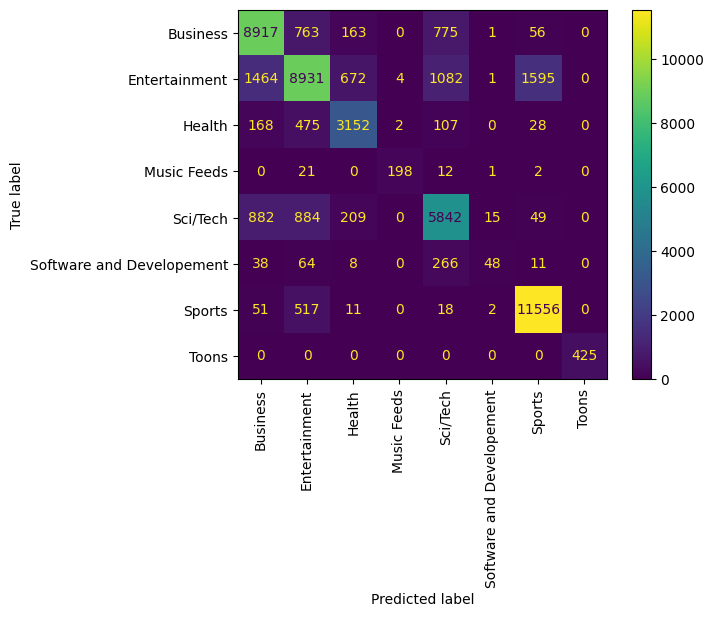

In [139]:
"""
[TO BE IMPLEMENTED]

Plot a confusion matrix for the news category classification model trained above.
You should have a NxN matrix M, where
N = len(LABEL_SET)
M(i, j) = number of instances in the test set where true_label = LABEL_SET[i] and pred_label = LABEL_SET[j]

Hint: check out sklearn.metrics

"""

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, Y_pred, labels = model.classes_)

cm_display = ConfusionMatrixDisplay(cm, display_labels = model.classes_).plot(xticks_rotation = 'vertical')

In [138]:
"""
[TO BE IMPLEMENTED]

Compute the precision, recall and F1 score per-class for the test set

Hint: check out sklearn.metrics
"""
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))


                           precision    recall  f1-score   support

                 Business       0.77      0.84      0.80     10675
            Entertainment       0.77      0.65      0.70     13749
                   Health       0.75      0.80      0.77      3932
              Music Feeds       0.97      0.85      0.90       234
                 Sci/Tech       0.72      0.74      0.73      7881
Software and Developement       0.71      0.11      0.19       435
                   Sports       0.87      0.95      0.91     12155
                    Toons       1.00      1.00      1.00       425

                 accuracy                           0.79     49486
                macro avg       0.82      0.74      0.75     49486
             weighted avg       0.79      0.79      0.78     49486



In [154]:
import random

def confusion_matrix_errors(X, Y, preds, true_label, pred_label, num_errors=100):
    """
    [TO BE IMPLEMENTED]

    Write a function `confusion_matrix_errors` that accepts the following inputs:
    1. The test dataset
    2. True and predicted labels for each row in the dataset
    3. A pair of labels (T, P)

    And returns the `num_errors` no. of errors from the test dataset where true_label = T and pred_label = P
    """
    errors = [X_i for X_i, Y_true_i, Y_pred_i in zip(X, Y, preds) if Y_true_i == true_label and Y_pred_i == pred_label]
    return random.sample(errors, num_errors)


"""
[TO BE IMPLEMENTED]
Use the function implemented above to get some insights about the kind of examples that the model
is confused about for a given pair of classes
Some pairs to try out: ('Entertainment', 'Sports'), ('Health', 'Sports'), ('Business', 'Sci/Tech')
"""
print("Insights 1:")
for e in confusion_matrix_errors(Datasets['test'], Y_test, Y_pred, 'Entertainment', 'Sports', num_errors=5):
  print(e['description'])

print("\nInsights 2:")
for e in confusion_matrix_errors(Datasets['test'], Y_test, Y_pred, 'Health', 'Sports', num_errors=5):
  print(e['description'])

print("\nInsights 3:")
for e in confusion_matrix_errors(Datasets['test'], Y_test, Y_pred, 'Business', 'Sci/Tech', num_errors=5):
  print(e['description'])

  and should_run_async(code)



Insights 1:
AOL has filed two lawsuits, while EarthLink and Yahoo! each filed a single lawsuit. The three Microsoft lawsuits allege that defendants spoofed the domains of all four ISPs and used open proxies to route the emails.
AP - Santa Claus could not conquer "The Incredibles." The cartoon hit retained the top slot at the box office for a second weekend, taking in  #36;51 million to fend off animated newcomer "The Polar Express," a Christmas tale that debuted at No. 2 with  #36;23.5 million.
Last week, Microsoft posted a notice about a new kind of vulnerability in Windows machines. The MS04-028 announcement states that merely opening a JPEG image (one that had been tinkered with by a hacker, of
AP - Swarms of locusts that have devastated crops and pastures across West Africa may hit countries as far away as Pakistan, a U.N. agency said Wednesday as it announced an intensified control campaign.
ATHENS (Reuters) - The unbeaten U.S. women's basketball  team cruised to another victory W

## Step 4 (Part 2): Estimating confidence intervals with Bootstrap sampling

When computing model performance metrics, the margin of error can vary a lot depending on the size of the test dataset. We are trying to estimate the model’s performance on any unseen data by empirically computing the model performance on the held-out test set, and trying to quantify the confidence intervals in this estimation: If we were to measure the model’s performance on another independently collected test dataset from the same underlying distribution, our model’s performance on this dataset is unlikely to be the same, but how different might they plausibly be?

In this exercise, we will implement Bootstrap sampling to estimate the 95% confidence interval for
overall accuracy and F1-score of the model:

1. Generate N ‘bootstrap sample’ datasets, each the same size as the original test set. Each bootstrap sample dataset is obtained by sampling instances uniformly at random from the original test set (with replacement).
2. On each of the bootstrap sample datasets, calculate the accuracy metric.
3. From Step (2), you will end up with N different accuracy values. Sort them.
4. The 95% confidence interval is given by the 2.5th to the 97.5th percentile among the N sorted accuracy values.


In [163]:
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed


def bootstrap_accuracy_distribution(Y_true, Y_pred, N = 1000):
    """
    [TO BE IMPLEMENTED]

    Implement this function that takes two lists: Y_true, Y_pred
    and the number of bootstrap trials (N).

    It should return a list (ret) of length = N, where ret[i] = accuracy metric from i-th bootstrap sampling run
    """
    num_samples = len(Y_true)

    def bootstrap_trial():
        # Generate bootstrap sample indices
        sample_indices = np.random.choice(num_samples, size=num_samples, replace=True)

        # Create bootstrap samples
        Y_true_bootstrap = [Y_true[i] for i in sample_indices]
        Y_pred_bootstrap = [Y_pred[i] for i in sample_indices]

        # Calculate accuracy metric on bootstrap sample
        accuracy = accuracy_score(Y_true_bootstrap, Y_pred_bootstrap)
        return accuracy

    # Run bootstrap trials in parallel
    bootstrap_vals = Parallel(n_jobs=-1, verbose=1)(delayed(bootstrap_trial)() for _ in range(N))
    return bootstrap_vals



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.7min finished


95 percent confidence interval: [0.7860202885664632, 0.7932546578830376]


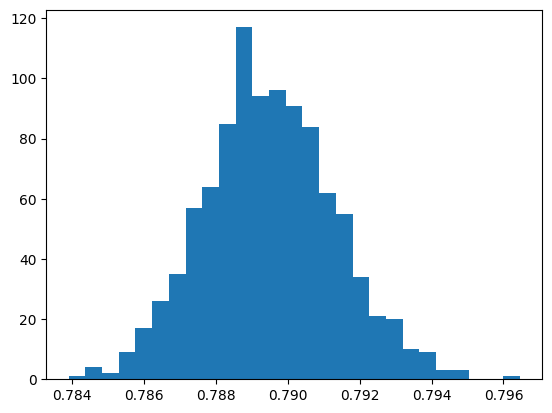

In [164]:
import matplotlib.pyplot as plt
NUM_BOOTSTRAP = 1000

bs_vals = bootstrap_accuracy_distribution(Y_test, Y_pred, NUM_BOOTSTRAP)
bs_vals = sorted(bs_vals)

print("95 percent confidence interval: [{0}, {1}]".format(
    bs_vals[25],    # 2.5th percentile
    bs_vals[975]    # 97.5th percentile
))

_ = plt.hist(bs_vals, bins='auto')
plt.show()

## Step 4 (Part 3): Minimum Functionality behavioral Tests

Unit tests and integration tests play an important role in testing software for bugs, inefficiencies and potential vulnerabilities. Can we employ a similar approach to testing ML models? This exercise introduces the concept of “behavioral testing”  for machine learning models.

Minimum Functionality Tests are a class of behavioral tests, and equivalents of “unit tests in software engineering” - a collection of simple examples (and labels) to check a behavior. A recommended practice is to write minimum functionality tests for highly visible/high cost potential failure modes, and for failure modes that you uncover during error analysis to guard against such failures in the future.

For this exercise, we will use a popular open source library called [Checklist](https://github.com/marcotcr/checklist) to configure and run behavioral tests for our model. The goal and scope of the exercise here is to get you acquainted with the library and practice of testing for minimum functionality.

Useful references:
1. Getting started with Checklist: https://github.com/marcotcr/checklist
2. Creating & Running tests with Checklist: https://github.com/marcotcr/checklist/blob/9baab717e44e216697f7ef0730ee269db9ef7d5b/notebooks/tutorials/3.%20Test%20types,%20expectation%20functions,%20running%20tests.ipynb

In [166]:
!pip install checklist

  and should_run_async(code)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.9 MB/s eta 0:00:00
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 24.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached qtconsole-5.4.3-py3-none-any.whl (121 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 80.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.4/348.4 kB 

In [167]:
import checklist
from checklist.editor import Editor
from checklist.test_types import MFT
from checklist.pred_wrapper import PredictorWrapper

# Run some warmup code to get you familiar with templates in checlist
editor = Editor()
ret = editor.template('{first_name} is {a:profession} from {country}.',
                      profession=['lawyer', 'doctor', 'accountant'])
np.random.choice(ret.data, 3)

array(['Scott is an accountant from Georgia.',
       'James is a lawyer from South Africa.',
       'Harold is a lawyer from Gabon.'], dtype='<U67')

In [168]:
"""
[TO BE IMPLEMENTED]

Part 1: Data Generation for behavioral tests

1. News Source variation:
{source}: Astronomers expect the Perseid meteor shower to be one of the best versions of the shooting star events in several years
source = ['New York Times', 'Reuters', 'AP', 'Wall Street Journal', 'Quanta', 'BBC', 'BBC UK', 'Yahoo News']
labels = "Sci/Tech"

2. Company Name variation:
{company} revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
company = ['McDonalds', 'Starbucks', 'Chipotle', 'Krispy Creme', 'Unknown Company']
labels = "Sci/Tech"

3.
{disease} will come under the {mask} during the charity gala event being held on Monday at 7pm
disease = ['Breast cancer', 'Heart disease', 'Diabetes']
labels = "Health"
"""

editor = Editor()
# [TO BE IMPLEMENTED]
source = ['New York Times', 'Reuters', 'AP', 'Wall Street Journal', 'Quanta', 'BBC', 'BBC UK', 'Yahoo News']
company = ['McDonalds', 'Starbucks', 'Chipotle', 'Krispy Creme', 'Unknown Company']
labels_1 = "Sci/Tech"
labels_2 = "Health"
disease = ['Breast cancer', 'Heart disease', 'Diabetes']

ret = editor.template('{source}: Astronomers expect the Perseid meteor shower to be one of the best versions of the shooting star events in several years', source= source, labels=labels_1, save=True, nsamples=100)
ret += editor.template('{company} revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.', company=company,  labels=labels_1, save=True, nsamples=100)
ret += editor.template('{disease} will come under the {mask} during the charity gala event being held on Monday at 7pm', disease=disease, labels=labels_2, save=True, nsamples=100)



  and should_run_async(code)



  to_pred = torch.tensor(to_pred, device=self.device).to(torch.int64)



In [169]:
"""
Part 2: Test Configuration
"""

test = MFT(**ret, name='AG News MFT tests')

In [170]:
"""
Part 3: Test Run & Results summary
"""

def encode_and_predict(inputs):
    encoder = SentenceTransformer(
        'sentence-transformers/{model}'.format(model=EMBEDDING_MODEL)
    )
    encodings = [encoder.encode(x, normalize_embeddings=True) for x in inputs]
    return model.predict(encodings)

# wrapped_pp returns a tuple with (predictions, softmax confidences)
wrapped_pp = PredictorWrapper.wrap_predict(encode_and_predict)
test.run(wrapped_pp, overwrite=True)
test.summary()

Predicting 300 examples


Test cases:      300
Fails (rate):    100 (33.3%)

Example fails:
Business Chipotle revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
----
Business Krispy Creme revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
----
Business Unknown Company revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
----


## Step 5: [Optional] Advanced data quality and behavioral tests

In the previous steps, you have familiarized yourself with libraries for writing data quality tests (great expectations) and behavioral tests (checkist). Take it out for a spin! A few possible extensions you can try:

1. **Model invariance behavioral tests** -- in step 4, we wrote some minimum functionality tests. Can you design some useful invariance behavioral tests?

2. **Embedding drift based data quality checks across Training/Test datasets** -- in step 3, we wrote some data quality tests. If we wanted to check for drift in embedding space between training and test data, how might we construct a data quality test for this? Hint: The distribution of euclidean distance between pairs of embeddings within the training, and between the training and test dataset should be “almost the same”



In [ ]:
!pip install 'deepchecks[nlp]'

In [25]:
from deepchecks.nlp import TextData

task_type = "text_classification"
train_text_data = TextData(raw_text=Datasets_filtered['train'].description.tolist(), embeddings=np.array(X_train), label=Y_train, task_type=task_type)
test_text_data = TextData(raw_text=Datasets_filtered['test'].description.tolist(),embeddings=np.array(X_test), label=Y_test, task_type=task_type)


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




In [26]:
from deepchecks.nlp.checks import TextEmbeddingsDrift

check = TextEmbeddingsDrift()
result = check.run(train_dataset=train_text_data, test_dataset=test_text_data)
result

deepchecks - WARNING - Could not find model's classes, using the observed classes


<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Embeddings Drift

## Step 6 [Optional] Examing the impact of label noise on model performance

we have studied the impact of intelligently augmenting data to improve model performance. An equally important consideration is the quality of labels (both in the training and validation datasets) - label noise can lead to suboptimal performance in two ways:
(i) noise in the validation dataset can lead us to compute model performance on incorrect ground truth labels
(ii) noise in the training dataset can lead the model to learning incorrect correlations between input features and the ground truth label.

[Cleanlab](https://docs.cleanlab.ai/stable/index.html) is a popular open source library to detect and fix label errors in datasets, by using a technique called confident learning. If you are interested to learn more, take a look at:
* published paper: https://jair.org/index.php/jair/article/view/12125
* blog: https://l7.curtisnorthcutt.com/confident-learning

Use Cleanlab to identify labeling errors in the AG News dataset, and report any improvement in model performance. Note that

Some starter tutorials/code snippets that might be helpful:
* [Text classification tutorial](https://docs.cleanlab.ai/stable/tutorials/text.html)
* [API Documentation](https://docs.cleanlab.ai/stable/index.html)
* [Common example notebooks](https://github.com/cleanlab/examples)

In [ ]:
'''
[TO BE IMPLEMENTED]

Your label noise experimentations go here

For instance, one exploration might look like the following:

import cleanlab

## Train cleanlab model
cl = cleanlab.classification.CleanLearning(
  LogisticRegression(
    multi_class='multinomial',
    tol=0.001,
    solver='saga',
))
cl.fit(<train>, <train labels>)

## Use the trained model to identify potential issues
label_issues_training = cl.find_label_issues(<train labels>, cl.predict(<train>))
label_issues_test = cl.find_label_issues(<test labels>, cl.predict(<test>))

## Use the identified issues to update the ground truth labels
## Train the new model and record performance improvements

'''